In [1]:
!pip install pytorch_lightning
!pip install torchvision
!pip install ffmpeg-python

In [2]:
import cv2
import numpy as np

import torch, time, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import PIL

import pandas as pd

import time, ffmpeg
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import InterpolationMode

In [3]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
video_path = '/content/drive/MyDrive/Lara-video.mpg'
labels_path = '/content/drive/MyDrive/Lara-labels.txt'

In [5]:
class FlipImage(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, sample):
        h,w = sample['image'].shape[1:]
        sample['image'] = transforms.RandomHorizontalFlip(self.p)(sample['image'])

        x1,x2,y1,y2,subtype = sample['bbox']
        x1 = w-x1
        x2 = w-x2
        sample['bbox'] = x1,x2,y1,y2,subtype

        return sample
class Resize(object):
    def __init__(self, image_size, interpolation=2):
        self.image_size = image_size # (h,w)
        self.interpolation = interpolation
    def __call__(self, sample):
        old_h, old_w = sample['image'].shape[1:]
        h, w = self.image_size
        sample['image'] = transforms.Resize(self.image_size, self.interpolation)(sample['image'])

        x1,x2,y1,y2,subtype = sample['bbox']
        x1 = round(x1*old_w/w)
        x2 = round(x2*old_w/w)
        y1 = round(y1*old_h/h)
        y2 = round(y2*old_h/h)
        sample['bbox'] = x1,x2,y1,y2,subtype

        return sample
class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        sample['image'] = transforms.ToTensor()(sample['image'])
        return sample
class Normalize(object):
    def __init__(self, arg1, arg2):
        self.arg1 = arg1
        self.arg2 = arg2
    def __call__(self, sample):
        sample['image'] = transforms.Normalize(self.arg1, self.arg2)(sample['image'])
        return sample
class CropImage(object):
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, sample):
        image=sample['image']
        h, w = image.shape[1:]
        type_crop = type(self.crop_size)

        if type_crop == int:
            top=bottom=left=right=self.crop_size
        elif type_crop == tuple:
            top, bottom, left, right = self.crop_size
        elif type_crop == float and self.crop_size >0 and self.crop_size <1:
            top=bottom=h-(h*self.crop_size)
            left=right=w-(w*self.crop_size)
        else:
            raise Exception(ValueError)
            
        sample['image'] = image[:,0+top : h-bottom, 0+left : w-right]
        print(sample['image'].shape)
        return sample

In [14]:
class TrafficLightsDataset(torch.utils.data.IterableDataset):
    """Traffic lights dataset."""
      
    def ffmpeg_process(self, video_file):
        probe = ffmpeg.probe(video_file)
        video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
        old_width = int(video_info['width'])
        old_height = int(video_info['height'])
        num_frames = int(eval(video_info['duration'])*eval(video_info['avg_frame_rate']))
        
        frame_size = old_width*old_height*3
        #print(frame_idx)
        process = (
            ffmpeg
            .input(video_file)
            .filter('scale', old_width, old_height)
            .output('pipe:', format='rawvideo', pix_fmt='rgb24')
            .run_async(pipe_stdout=True)
        )
        print('ffmeg process')
        return process, num_frames, {'frame_size': frame_size, 
                                     'height': old_height, 
                                     'width': old_width}

    def labels_loader(self, frame_index, max_traffic_lights=10):
        df = self.labels_df
        frame_labels = df[(df.frameindex==frame_index) & (df.type=='traffic-light')]
        signal_mapping = {"stop": 0, "warning": 1, "go": 2, "ambigous": 3}
        tl_signals = frame_labels.subtype.replace(signal_mapping).values
        frame_labels = np.hstack([frame_labels.values[:, 1:5], tl_signals.reshape(-1,1)]).astype(dtype=np.int32)
        frame_labels_padded = np.zeros((10,5))
        frame_labels_padded[:, 4] = -1
        frame_labels_padded[:frame_labels.shape[0], :frame_labels.shape[1]] = frame_labels

        frame_index = df.frameindex.tolist()
        index_map = dict(enumerate(frame_index))
        index_map = {(y,x) for x,y in index_map.items()}
        return frame_labels_padded

    def __init__(self, video_file, labels_file, transform=None):
        self.process, self.num_frames, self.video_meta = self.ffmpeg_process(video_file)
        self.transform = transform
        self.cnt = 0
        self.labels_df = pd.read_csv(labels_file, sep=' ')

    def __len__(self):
        return self.num_frames

    def __iter__(self):
                                     
        frame_size = self.video_meta['frame_size']
        old_width = self.video_meta['width']
        old_height = self.video_meta['height']
        for i in range(self.num_frames):
            print('123')
            frame = (
                np
                .frombuffer(self.process.stdout.read(frame_size), np.uint8)
                .reshape(3,old_height, old_width)
            )
            image = torch.tensor(frame, dtype=torch.int32)
            bbox = self.labels_loader(self.cnt)
            sample = {'image': image, 'bbox': bbox}
            if self.transform:
                sample = self.transform(sample)        
            yield sample

In [7]:
classes = ('go', 'warning', 'stop')

def get_loaders(video_path, labels_path, batch_size=128, num_workers=2, transform=transforms.ToTensor()):
    dataset = TrafficLightsDataset(video_path, labels_path, transform=transform)
    
    test_size = int(0.2*len(dataset))
    train_size = len(dataset) - test_size
    train, test = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    return train_loader, test_loader

classes = ('go', 'warning', 'stop')

def get_loaders(video_path, labels_path, batch_size=128, num_workers=2, transform=transforms.ToTensor()):
    dataset = TrafficLightsDataset(video_path, labels_path, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    #test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    return train_loader, None

In [9]:
transform=transforms.Compose([
    #Resize((432,576), interpolation=InterpolationMode.BILINEAR),
    CropImage((0,0,0,0)),
    #FlipImage(0.5),
    #Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [24]:
sample['bbox'].shape, sample['image'].shape

(torch.Size([10, 10, 5]), torch.Size([10, 3, 480, 640]))

ffmeg process
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
123
Tensor shape: torch.Size([10, 3, 480, 640]) BatchxCxHxW
torch.Size([10, 3, 480, 640])
0
1
2
3
4
5
6
7
8
9


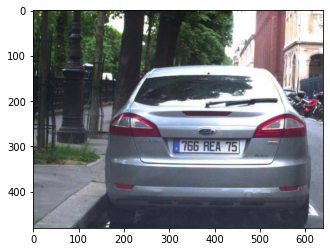

In [20]:
train_loader,_ = get_loaders(video_path, labels_path, batch_size=10, num_workers=1, transform=None)
sample = iter(train_loader).next()
print("Tensor shape: {} BatchxCxHxW".format(sample['image'].shape))
#bbox = np.array(sample['bbox'])
images = sample['image']
print(images.shape)

import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    #print(classes[labels[i]])
    print(i)
    img = images[i]
    img = img.reshape((480, 640, 3))
    plt.imshow(img)